In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import IPython.display
from utils import *

In [2]:
def calculate_poincare_index(orientations, mask, step=16, window_size=3, poincare_tolerance_degrees=45):
    h, w = orientations.shape
    singular_points = []
    
    for y in range(window_size, h - window_size, step):
        for x in range(window_size, w - window_size, step):
            if mask[y, x] == 0:
                continue
            path_points = []
            for i in range(x - window_size, x + window_size + 1):
                path_points.append((i, y - window_size))
            for j in range(y - window_size + 1, y + window_size + 1):
                path_points.append((x + window_size, j))
            for i in range(x + window_size - 1, x - window_size - 1, -1):
                path_points.append((i, y + window_size))
            for j in range(y + window_size - 1, y - window_size, -1):
                path_points.append((x - window_size, j))

            unique_path_points = []
            seen = set()
            for px, py in path_points:
                if 0 <= px < w and 0 <= py < h:
                    if (px, py) not in seen:
                        unique_path_points.append((px, py))
                        seen.add((px, py))
            
            path_points = unique_path_points
            
            if len(path_points) < 8:
                continue

            poincare_index_radians = 0
            N = len(path_points)
            for i in range(N):
                p1_x, p1_y = path_points[i]
                p2_x, p2_y = path_points[(i + 1) % N]
                
                theta1 = orientations[p1_y, p1_x]
                theta2 = orientations[p2_y, p2_x]
                
                diff = theta2 - theta1
                if diff > np.pi / 2:
                    diff -= np.pi
                elif diff < -np.pi / 2:
                    diff += np.pi
                
                poincare_index_radians += diff
            
            poincare_index_degrees = np.degrees(poincare_index_radians)
            
            if abs(poincare_index_degrees - 180) < poincare_tolerance_degrees:
                singular_points.append({'type': 'core', 'coords': (x, y), 'index': poincare_index_degrees})
            elif abs(poincare_index_degrees + 180) < poincare_tolerance_degrees:
                singular_points.append({'type': 'delta', 'coords': (x, y), 'index': poincare_index_degrees})
            elif abs(poincare_index_degrees - 360) < poincare_tolerance_degrees:
                singular_points.append({'type': 'whorl_core', 'coords': (x, y), 'index': poincare_index_degrees})

    return singular_points

In [3]:
# def calculate_poincare_index(orientations, mask, step=16, window_size=3):
#     h, w = orientations.shape
#     singular_points = []
    
#     for y in range(window_size, h - window_size, step):
#         for x in range(window_size, w - window_size, step):
#             if mask[y, x] == 0:
#                 continue
            
#             path_points = []
#             for i in range(x - window_size, x + window_size + 1):
#                 path_points.append((i, y - window_size))
#             for j in range(y - window_size + 1, y + window_size + 1):
#                 path_points.append((x + window_size, j))
#             for i in range(x + window_size - 1, x - window_size - 1, -1):
#                 path_points.append((i, y + window_size))
#             for j in range(y + window_size - 1, y - window_size, -1):
#                 path_points.append((x - window_size, j))

#             path_points = [(px, py) for px, py in path_points if 0 <= px < w and 0 <= py < h]
            
#             if len(path_points) < 8:
#                 continue

#             poincare_index = 0
#             for i in range(len(path_points)):
#                 p1_x, p1_y = path_points[i]
#                 p2_x, p2_y = path_points[(i + 1) % len(path_points)]
                
#                 theta1 = orientations[p1_y, p1_x]
#                 theta2 = orientations[p2_y, p2_x]
                
#                 diff = theta2 - theta1
#                 if diff > np.pi / 2:
#                     diff -= np.pi
#                 elif diff < -np.pi / 2:
#                     diff += np.pi
                
#                 poincare_index += diff
            
#             poincare_index_degrees = np.degrees(poincare_index)
            
#             if abs(poincare_index_degrees - 180) < 90:
#                 singular_points.append({'type': 'core', 'coords': (x, y), 'index': poincare_index_degrees})
#             elif abs(poincare_index_degrees + 180) < 90:
#                 singular_points.append({'type': 'delta', 'coords': (x, y), 'index': poincare_index_degrees})
#             elif abs(poincare_index_degrees - 360) < 90:
#                 singular_points.append({'type': 'whorl_core', 'coords': (x, y), 'index': poincare_index_degrees})

#     return singular_points

# Wczytywanie odcisku palca

In [4]:
fingerprint = cv.imread('samples/sample_1_1.png', cv.IMREAD_GRAYSCALE)

""
""

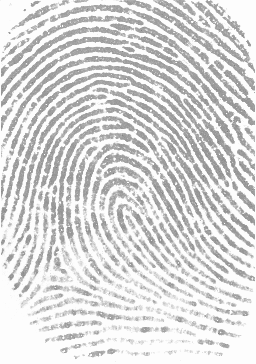

In [5]:
show(fingerprint)

In [6]:
# fingerprint = cv.boxFilter(fingerprint, -1, (10,10))

# Używanie filtru Sobel'a do uwypuklenia krawędzi

In [7]:
gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)

,
,

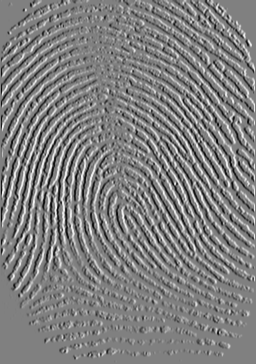
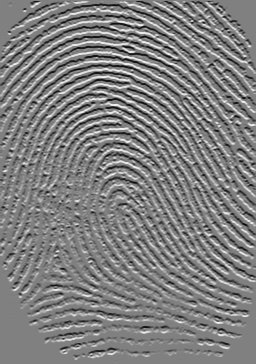

In [8]:
show(gx, gy)

In [9]:
gx2, gy2 = gx**2, gy**2
gm = np.sqrt(gx2 + gy2)

""
""

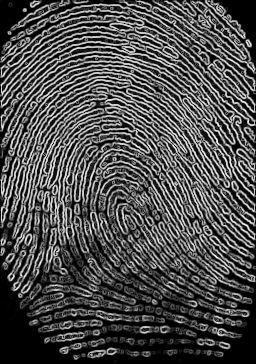

In [10]:
show(gm)

# Tworzenie maski

In [11]:
sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
thr = sum_gm.max() * 0.2
mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)

,,
,,

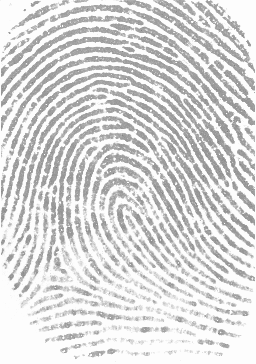
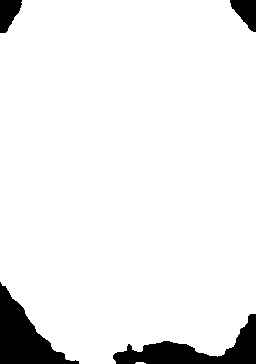
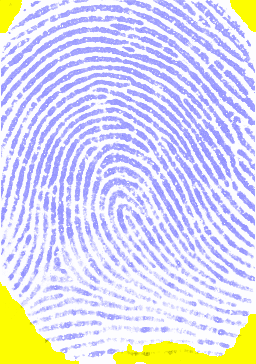

In [12]:
show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))

# Znajdywanie mapy orientacji

In [13]:
W = (23, 23)
gxx = cv.boxFilter(gx2, -1, W, normalize = False)
gyy = cv.boxFilter(gy2, -1, W, normalize = False)
gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
gxx_gyy = gxx - gyy
gxy2 = 2 * gxy

In [14]:
orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
sum_gxx_gyy = gxx + gyy
strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)

Orientation image
""

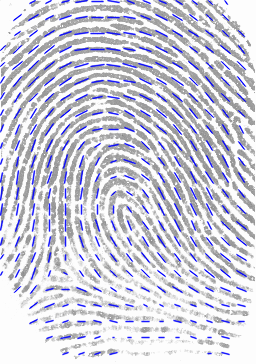

In [15]:
show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')

# Szukanie cech pierwszego poziomu na podstawie mapy orientacji

Tu jest parę mankamentów. Dla niektórych odcisków albo nie znajduje wszystkich punktów osobliwych, albo znajduje ich za dużo.  

Można próbować z tym walczyć zmieniając różne parametry, jak np. step, window_size. Można też próbować nakładać filtry rozmywające, np. boxFilter na samym początku.  

Niestety, jeśli udało mi się dopasować te parametry do jakiegoś odcisku, to coś się psuło dla tych, które wcześniej działały. Ale myślę, że da się to może jakoś próbować poprawiać i dopasowywać dla każdego odcisku może?

Aha no i jeszcze do dorobienia jest samo jakby nazywanie typu odcisku, czyli czy to wir, czy pętla lewa, czy prawa, czy może coś innego, to można zrobić na podstawie tych punktów osobliwych i ich wzajemnego rozmieszcenia.

In [16]:
singular_points = calculate_poincare_index(orientations, mask, step=10, window_size=5)

In [17]:
print("Wykryte punkty osobliwe:")
for sp in singular_points:
    print(f"Typ: {sp['type']}, Współrzędne: {sp['coords']}, Indeks Poincarego: {sp['index']:.2f} stopni")

Wykryte punkty osobliwe:
Typ: delta, Współrzędne: (125, 205), Indeks Poincarego: -180.00 stopni
Typ: core, Współrzędne: (55, 275), Indeks Poincarego: 180.00 stopni


In [18]:
result_image = draw_orientations(fingerprint, orientations, strengths, mask, 1, 16)
for sp in singular_points:
    x, y = sp['coords']
    scaled_x, scaled_y = x, y
    color = (0, 0, 255) if sp['type'] == 'core' else (0, 255, 0)
    cv.circle(result_image, (scaled_x, scaled_y), 40, color, 2)
    # cv.putText(result_image, sp['type'], (scaled_x + 15, scaled_y), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

""
""

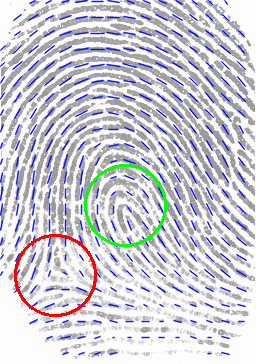

In [19]:
show(result_image)

# Wyszukiwanie odcisków w bazie danych

To jest do dorobienia